Epoch 1/100


C:\Users\elbostan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_46']. Received: the structure of inputs=*
  warnings.warn(


15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.6947 - mean_iou: 0.3701
Epoch 1: val_loss improved from inf to 0.67763, saving model to unet_best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - loss: 0.6940 - mean_iou: 0.3752 - val_loss: 0.6776 - val_mean_iou: 0.5382
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.6651 - mean_iou: 0.5951
Epoch 2: val_loss improved from 0.67763 to 0.65728, saving model to unet_best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.6644 - mean_iou: 0.5954 - val_loss: 0.6573 - val_mean_iou: 0.5494
Epoch 3/100
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.6071 - mean_iou: 0.6307
Epoch 3: val_loss improved from 0.65728 to 0.62838, saving model to unet_best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.6082 - mean_iou: 0.6295 - val_loss: 0.6284 - val_mean_iou: 0.5927
Epoch 4/100
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.5966 - mean_iou: 0.6528
Epoch 4: val_loss improved from 0.62838 to 0.57494,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5647059082984924..10.58431339263916].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5647059082984924..10.58431339263916].


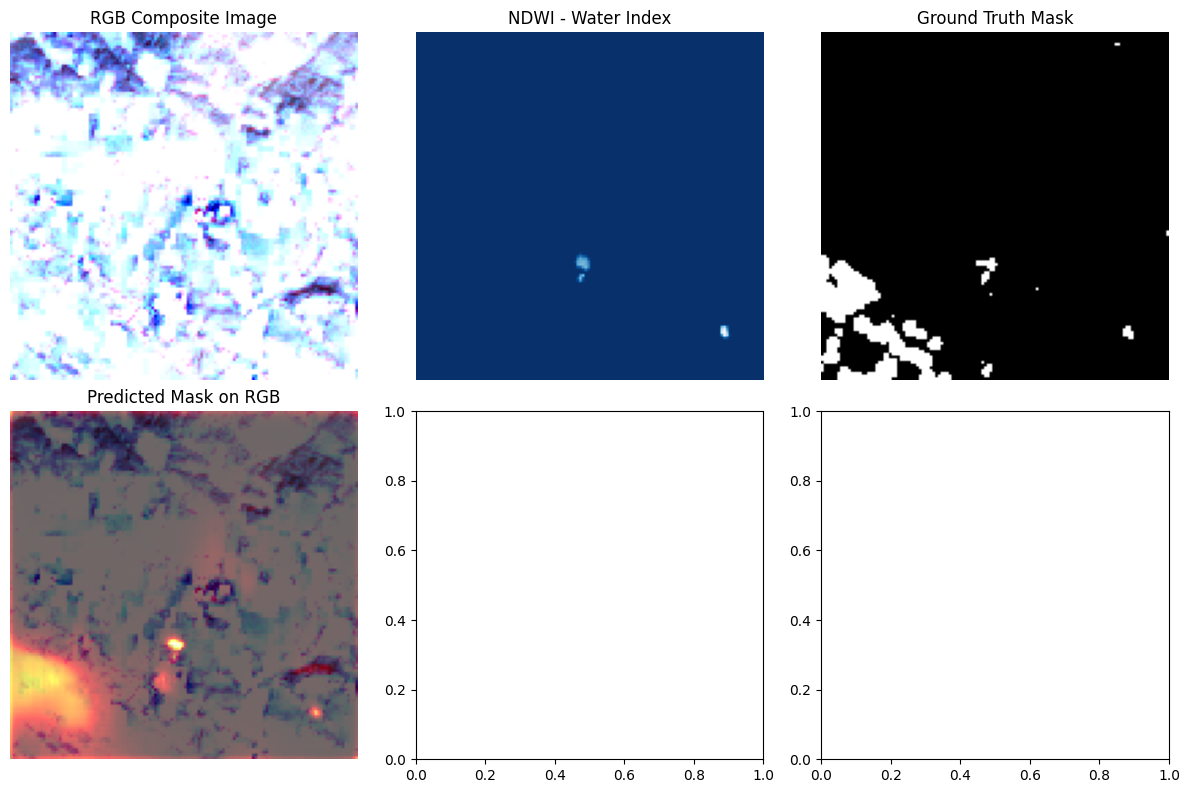

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.058823585510254..18.145097732543945].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.058823585510254..18.145097732543945].


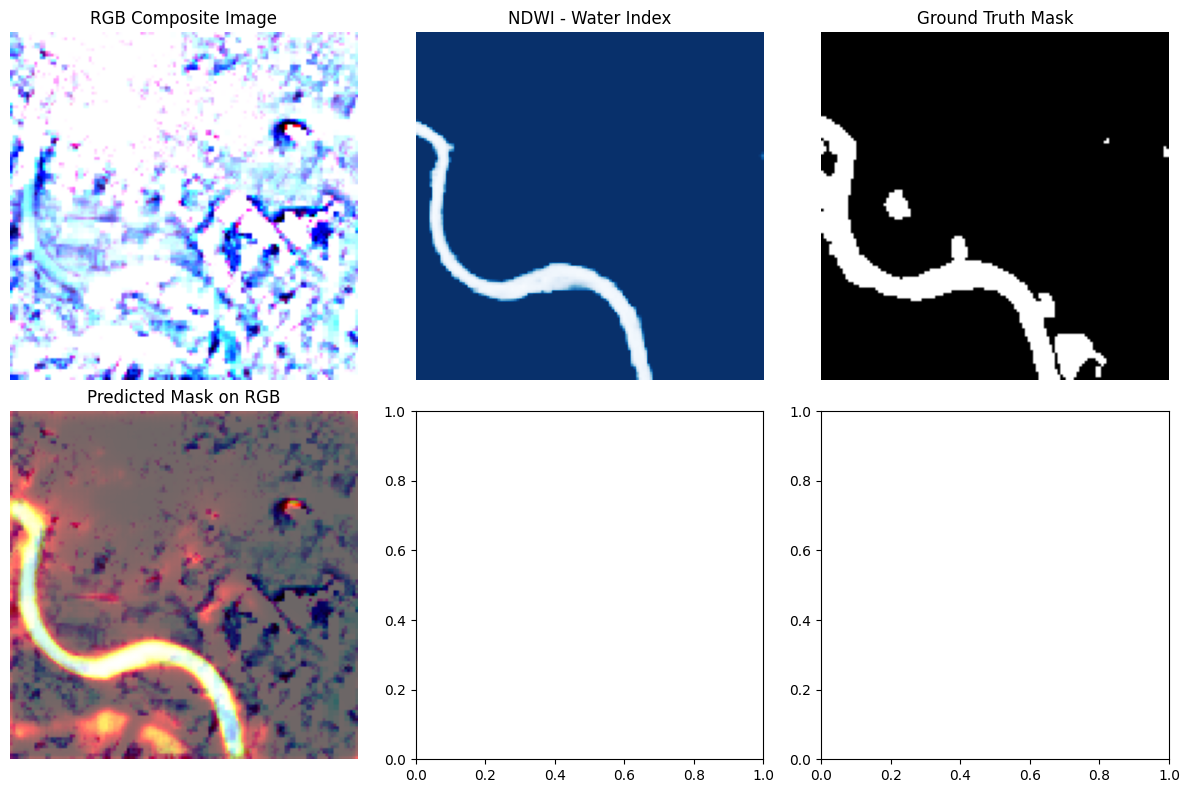

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2705882489681244..6.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2705882489681244..6.0].


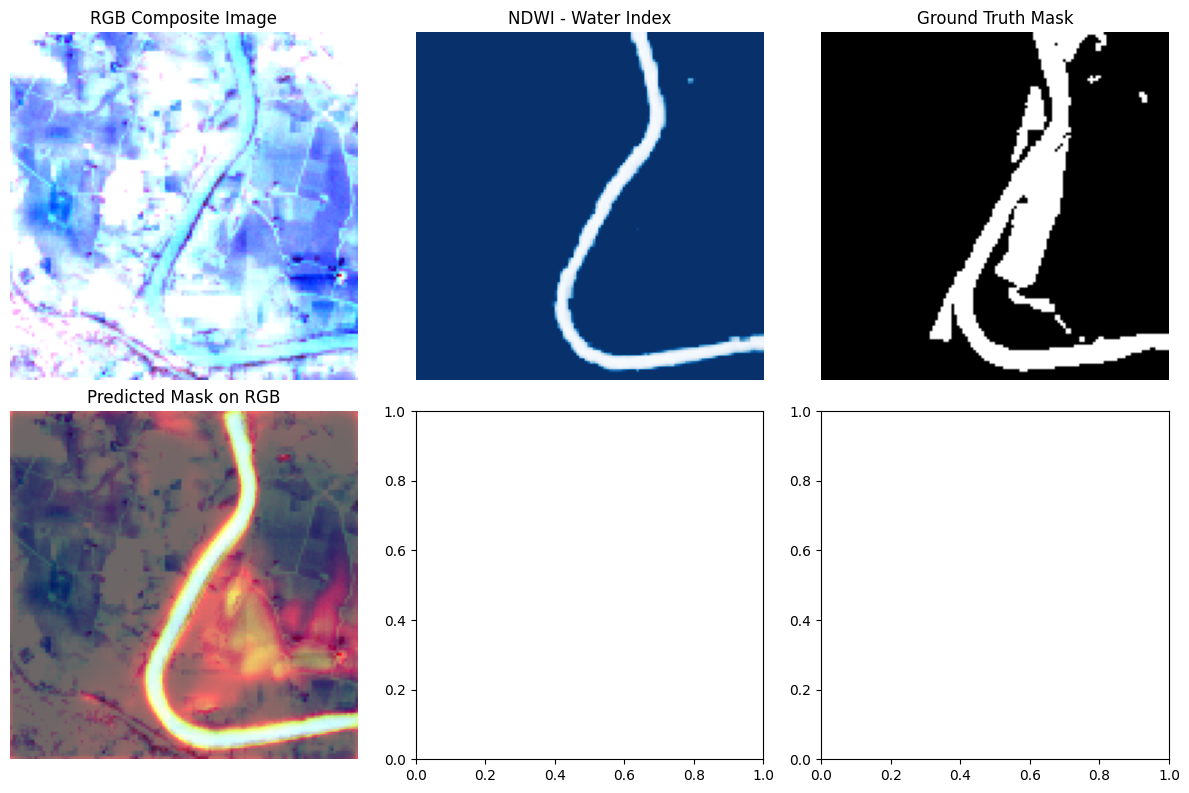

In [2]:
import os
import shutil
import numpy as np
import imageio.v2 as imageio
import rasterio
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K

# Define paths
images_path = 'data/images'
labels_path = 'data/labels'
filtered_labels_path = 'data/filtered_labels'

os.makedirs(filtered_labels_path, exist_ok=True)

# Function to prepare labels
def prepare_labels(labels_path, filtered_labels_path):
    label_filenames = sorted(os.listdir(labels_path))
    valid_labels = sorted([f for f in label_filenames if f.endswith('.png') and f.split('.')[0].isdigit()])
    for label in valid_labels:
        shutil.copy(os.path.join(labels_path, label), os.path.join(filtered_labels_path, label))
    return valid_labels

valid_labels = prepare_labels(labels_path, filtered_labels_path)

# Function to compute NDWI
def compute_ndwi(image_path):
    with rasterio.open(image_path) as src:
        nir = src.read(8).astype(float)  # NIR band (detects water)
        swir = src.read(11).astype(float)  # SWIR1 band (detects water)

    epsilon = 1e-10
    ndwi = (nir - swir) / (nir + swir + epsilon)  # NDWI Calculation
    return np.expand_dims(ndwi, axis=-1)

# Function to load and preprocess data
def load_and_preprocess_data(images_path, labels_path):
    images, labels = [], []
    image_filenames = sorted(os.listdir(images_path))
    label_filenames = sorted(os.listdir(labels_path))

    for img_file, label_file in zip(image_filenames, label_filenames):
        img_path = os.path.join(images_path, img_file)
        label_path = os.path.join(labels_path, label_file)

        with rasterio.open(img_path) as src:
            img = src.read().astype(np.float32)
            img = np.moveaxis(img, 0, -1)  # Channels to last axis

        label = imageio.imread(label_path).astype(np.uint8)

        if img.shape[:2] == (128, 128):
            img = img / 255.0  # Normalize images
            ndwi = compute_ndwi(img_path)  # Compute NDWI
            img = np.concatenate([img, ndwi], axis=-1)  # Add NDWI channel
            images.append(img)
            labels.append(label)

    return np.array(images), np.array(labels)

# Load and preprocess data
X, Y = load_and_preprocess_data(images_path, filtered_labels_path)

# Split dataset into train, validation, and test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

Y_train = np.expand_dims(Y_train, axis=-1)
Y_val = np.expand_dims(Y_val, axis=-1)
Y_test = np.expand_dims(Y_test, axis=-1)

# U-Net Model
def unet(sz=(128, 128, 13)):
    inputs = Input(sz)
    f = 4  # Initial filter size
    layers = []
    x = inputs

    # Downsampling
    for i in range(6):
        x = Conv2D(f, 3, activation='relu', padding='same')(x)
        x = Conv2D(f, 3, activation='relu', padding='same')(x)
        layers.append(x)
        x = MaxPooling2D()(x)
        f *= 2

    ff2 = 64

    # Bottleneck
    j = len(layers) - 1
    x = Conv2D(f, 3, activation='relu', padding='same')(x)
    x = Conv2D(f, 3, activation='relu', padding='same')(x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same')(x)
    x = Concatenate(axis=3)([x, layers[j]])
    j -= 1

    # Upsampling
    for i in range(5):
        ff2 //= 2
        f //= 2
        x = Conv2D(f, 3, activation='relu', padding='same')(x)
        x = Conv2D(f, 3, activation='relu', padding='same')(x)
        x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same')(x)
        x = Concatenate(axis=3)([x, layers[j]])
        j -= 1

    x = Conv2D(f, 3, activation='relu', padding='same')(x)
    x = Conv2D(f, 3, activation='relu', padding='same')(x)
    outputs = Conv2D(1, 1, activation='sigmoid')(x)

    return Model(inputs=[inputs], outputs=[outputs])

# Define IoU metric
def mean_iou(y_true, y_pred):
    y_true = K.cast(y_true, K.floatx())
    y_pred = K.round(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return intersection / (union + K.epsilon())

# Compile model
model = unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])

# Train model
checkpoint = ModelCheckpoint("unet_best_model.keras", monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100,
    batch_size=16,
    callbacks=[checkpoint, early_stopping]
)



In [5]:
import os
import shutil
import numpy as np
import imageio.v2 as imageio
import rasterio
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K

# Define paths
images_path = 'data/images'
labels_path = 'data/labels'
filtered_labels_path = 'data/filtered_labels'

os.makedirs(filtered_labels_path, exist_ok=True)

# Function to prepare labels
def prepare_labels(labels_path, filtered_labels_path):
    label_filenames = sorted(os.listdir(labels_path))
    valid_labels = sorted([f for f in label_filenames if f.endswith('.png') and f.split('.')[0].isdigit()])
    for label in valid_labels:
        shutil.copy(os.path.join(labels_path, label), os.path.join(filtered_labels_path, label))
    return valid_labels

valid_labels = prepare_labels(labels_path, filtered_labels_path)

# Function to compute NDWI
def compute_ndwi(image_path):
    with rasterio.open(image_path) as src:
        nir = src.read(8).astype(float)  # NIR band
        swir = src.read(11).astype(float)  # SWIR1 band

    epsilon = 1e-10
    ndwi = (nir - swir) / (nir + swir + epsilon)
    return np.expand_dims(ndwi, axis=-1)

# Function to load and preprocess data
def load_and_preprocess_data(images_path, labels_path):
    images, labels = [], []
    image_filenames = sorted(os.listdir(images_path))
    label_filenames = sorted(os.listdir(labels_path))

    for img_file, label_file in zip(image_filenames, label_filenames):
        img_path = os.path.join(images_path, img_file)
        label_path = os.path.join(labels_path, label_file)

        with rasterio.open(img_path) as src:
            img = src.read().astype(np.float32)
            img = np.moveaxis(img, 0, -1)

        label = imageio.imread(label_path).astype(np.uint8)

        if img.shape[:2] == (128, 128):
            img = img / 255.0  # Normalize images
            ndwi = compute_ndwi(img_path)
            img = np.concatenate([img, ndwi], axis=-1)
            images.append(img)
            labels.append(label)

    return np.array(images), np.array(labels)

# Load and preprocess data
X, Y = load_and_preprocess_data(images_path, filtered_labels_path)

# Split dataset into train, validation, and test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

Y_train = np.expand_dims(Y_train, axis=-1)
Y_val = np.expand_dims(Y_val, axis=-1)
Y_test = np.expand_dims(Y_test, axis=-1)

# U-Net Model
def unet(sz=(128, 128, 13)):
    inputs = Input(sz)
    f = 4
    layers = []
    x = inputs

    # Downsampling
    for i in range(6):
        x = Conv2D(f, 3, activation='relu', padding='same')(x)
        x = Conv2D(f, 3, activation='relu', padding='same')(x)
        layers.append(x)
        x = MaxPooling2D()(x)
        f *= 2

    ff2 = 64

    # Bottleneck
    j = len(layers) - 1
    x = Conv2D(f, 3, activation='relu', padding='same')(x)
    x = Conv2D(f, 3, activation='relu', padding='same')(x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same')(x)
    x = Concatenate(axis=3)([x, layers[j]])
    j -= 1

    # Upsampling
    for i in range(5):
        ff2 //= 2
        f //= 2
        x = Conv2D(f, 3, activation='relu', padding='same')(x)
        x = Conv2D(f, 3, activation='relu', padding='same')(x)
        x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same')(x)
        x = Concatenate(axis=3)([x, layers[j]])
        j -= 1

    x = Conv2D(f, 3, activation='relu', padding='same')(x)
    x = Conv2D(f, 3, activation='relu', padding='same')(x)
    outputs = Conv2D(1, 1, activation='sigmoid')(x)

    return Model(inputs=[inputs], outputs=[outputs])

# Define IoU metric
def mean_iou(y_true, y_pred):
    y_true = K.cast(y_true, K.floatx())
    y_pred = K.round(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return intersection / (union + K.epsilon())

# Compile model
model = unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])

# Train model
checkpoint = ModelCheckpoint("unet_best_model.keras", monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100,
    batch_size=16,
    callbacks=[checkpoint, early_stopping]
)

# Visualization function with heatmap
def plot_heatmap(image, mask_true, mask_pred):
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    # Show RGB composite image
    rgb_image = image[:, :, :3]  # Take the first three bands for RGB
    rgb_image = np.clip(rgb_image, 0, 1)  # Clip to [0, 1]
    axes[0, 0].imshow(rgb_image)
    axes[0, 0].set_title("RGB Composite Image")
    axes[0, 0].axis("off")

    # NDWI Heatmap
    ndwi = (image[:, :, 8] - image[:, :, 11]) / (image[:, :, 8] + image[:, :, 11] + 1e-10)
    axes[0, 1].imshow(ndwi, cmap='Blues')
    axes[0, 1].set_title("NDWI - Water Index")
    axes[0, 1].axis("off")

    # Ground Truth Mask
    axes[0, 2].imshow(mask_true.squeeze(), cmap="gray")
    axes[0, 2].set_title("Ground Truth Mask")
    axes[0, 2].axis("off")

    # Model Prediction Heatmap
    axes[1, 0].imshow(rgb_image)
    axes[1, 0].imshow(mask_pred.squeeze(), cmap="hot", alpha=0.6)
    axes[1, 0].set_title("Predicted Mask on RGB")
    axes[1, 0].axis("off")

    # Show contribution of NIR and SWIR bands
    axes[1, 1].imshow(image[:, :, 8], cmap='gray')  # NIR
    axes[1, 1].set_title("NIR Band")
    axes[1, 1].axis("off")

    axes[1, 2].imshow(image[:, :, 11], cmap='gray')  # SWIR1
    axes[1, 2].set_title("SWIR1 Band")
    axes[1, 2].axis("off")

    plt.tight_layout()
    plt.show()

Epoch 1/100


C:\Users\elbostan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_184']. Received: the structure of inputs=*
  warnings.warn(


15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.6805 - mean_iou: 0.0898
Epoch 1: val_loss improved from inf to 0.50668, saving model to unet_best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - loss: 0.6782 - mean_iou: 0.0832 - val_loss: 0.5067 - val_mean_iou: 8.9905e-06
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.4883 - mean_iou: 1.8146e-06
Epoch 2: val_loss improved from 0.50668 to 0.38477, saving model to unet_best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.4864 - mean_iou: 1.8786e-06 - val_loss: 0.3848 - val_mean_iou: 1.4682e-04
Epoch 3/100
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.4463 - mean_iou: 4.1226e-04
Epoch 3: val_loss improved from 0.38477 to 0.35954, saving model to unet_best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.4426 - mean_iou: 4.8562e-04 - val_loss: 0.3595 - val_mean_iou: 0.0037
Epoch 4/100
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.3826 - mean_iou: 0.0064
Epoch 4: val_loss improved 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


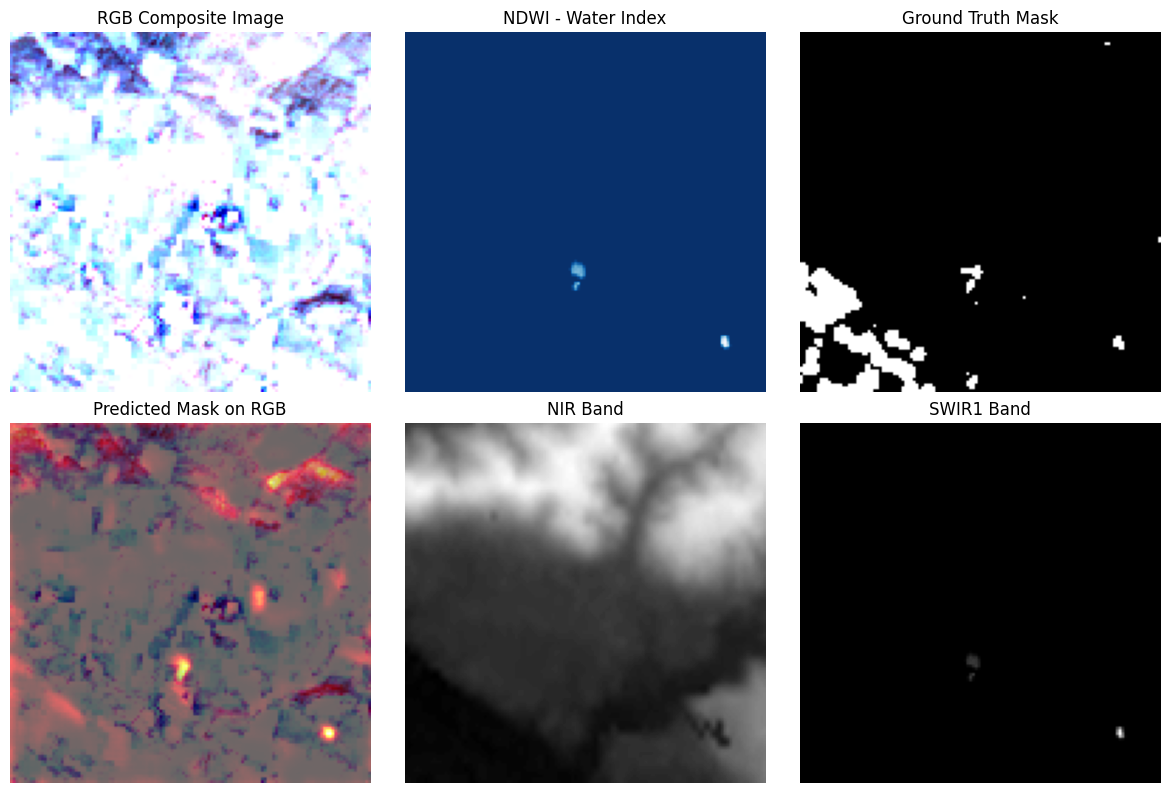

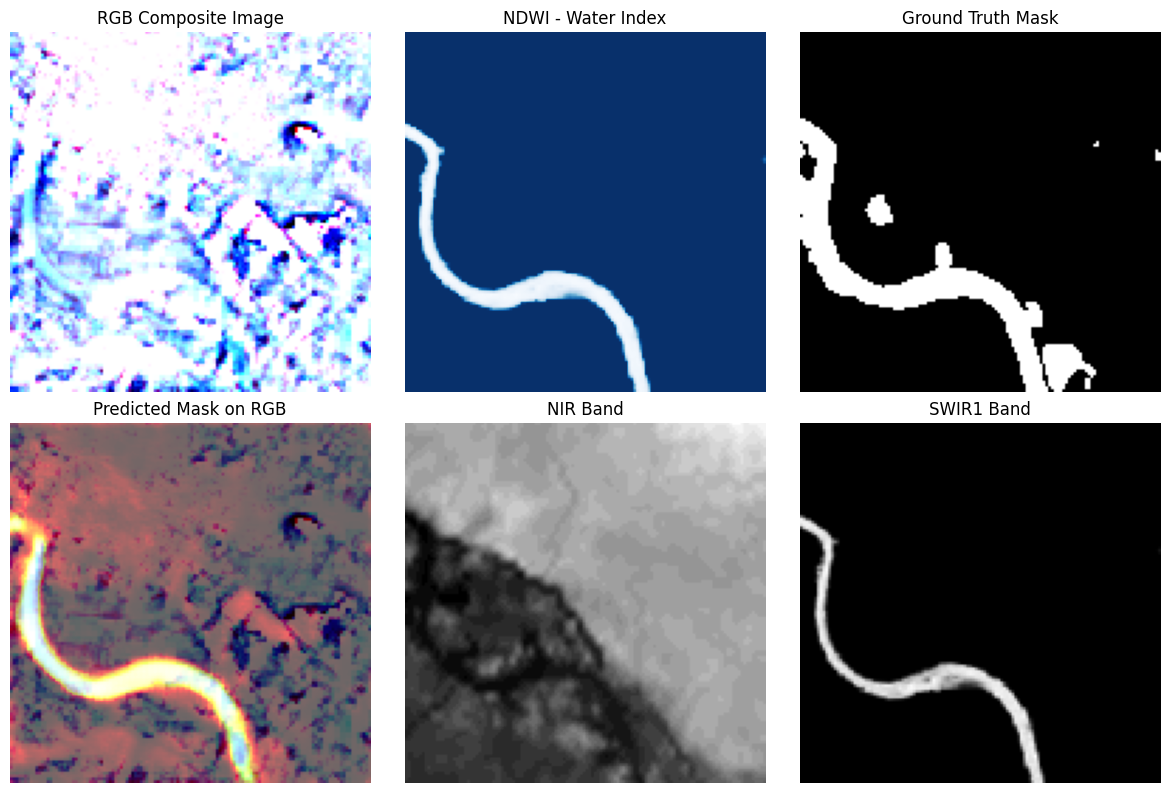

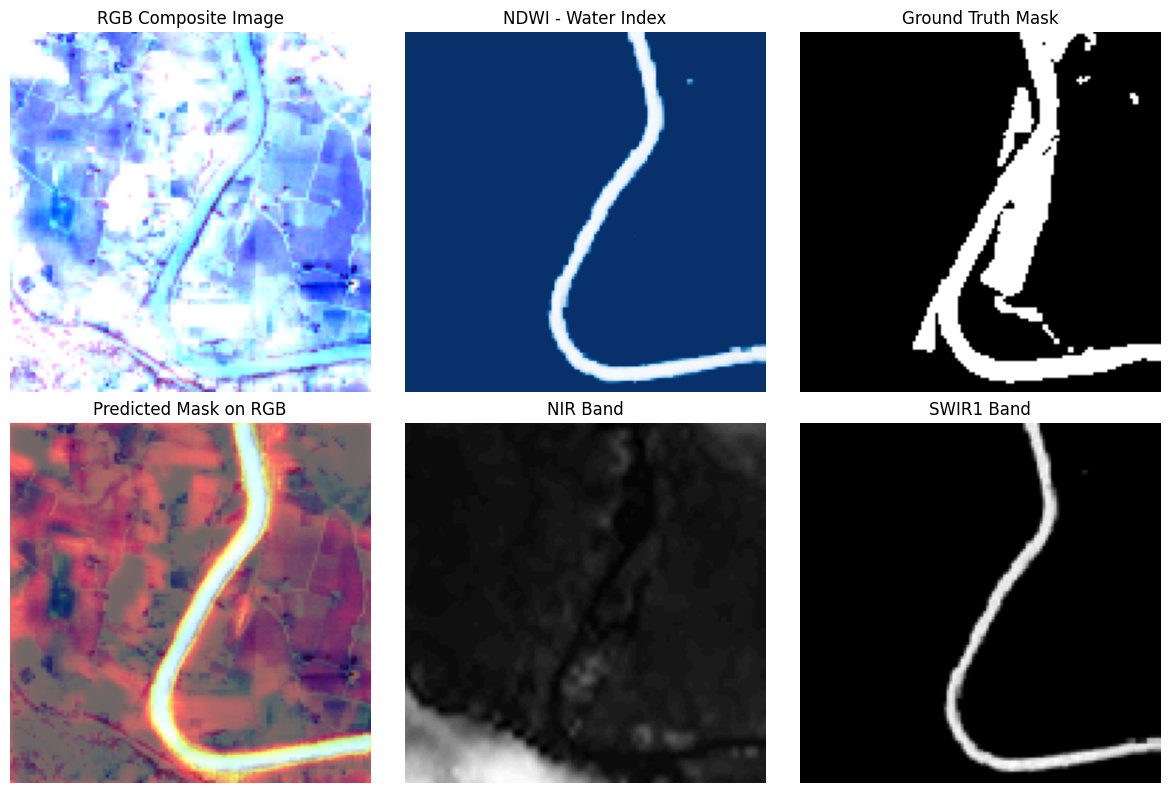

In [6]:
Y_pred = model.predict(X_test)
for idx in range(3):
    plot_heatmap(X_test[idx], Y_test[idx], Y_pred[idx])